In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from PySDM.physics import si
from PySDM.physics.formulae import volume
import numpy as np
from matplotlib import pyplot

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


# 1. Gamma distribution, constant kernel

Gamma distribution with N=1e7, k=3.2, theta=1.7;

Constant kernel = 9.26e-7;

Simulation time = 1 (1000 time steps)

In [36]:
# Set desired constants
K      = 9.2e-7        # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e7           # total number of droplets
end_step = int(T_sim / dt_sim)
k_shape = 3.2
theta_scale = 1.7

from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import ConstKern
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

Let's see an example of what the distributions will look like:

Text(0.5, 1.0, 'initial distribution')

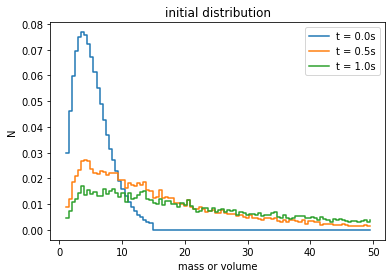

In [37]:
# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = K)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((1), (50), num=100)

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

Run the dynamics as prescribed, several times, and output the final distributions and moments

In [43]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=1))
    builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = K)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)

# save the data
np.savetxt('blind_test_1.out', moments, header="M0(0), M1(0), M2(0), M0(1), M1(1), M2(1)")

# 2. Gamma distribution, golovin kernel

Gamma distribution with N=1e7, k=3.2, theta=1.7;

Golovin kernel = 5.13e-8;

Simulation time = 1 (1000 time steps)

In [23]:
# Set desired constants
b_golovin= 5.13e-8       # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e7           # total number of droplets
end_step = int(T_sim / dt_sim)
k_shape = 3.2
theta_scale = 1.7

from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

Text(0.5, 1.0, 'initial distribution')

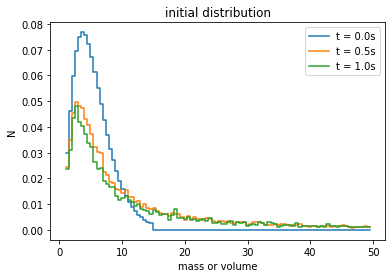

In [24]:
# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = b_golovin)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((1), (50), num=100)

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

In [25]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=1))
    builder.add_dynamic(Coalescence(kernel=Golovin(b=b_golovin)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)

# save the data
np.savetxt('blind_test_2.out', moments, header="M0(0), M1(0), M2(0), M0(1), M1(1), M2(1)")

# 3. Golovin kernel, exponential distribution

Exponential distribution with N=1e7, lambda=11.7;

Golovin kernel = 7.2e-8;

Simulation time = 1 (1000 time steps)

In [19]:
# Set desired constants
b_golovin= 7.2e-8       # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e7           # total number of droplets
end_step = int(T_sim / dt_sim)
lambda_scale = 11.7

from PySDM.initialisation.spectra import Exponential
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Exponential(norm_factor=N0, scale=lambda_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

Text(0.5, 1.0, 'initial distribution')

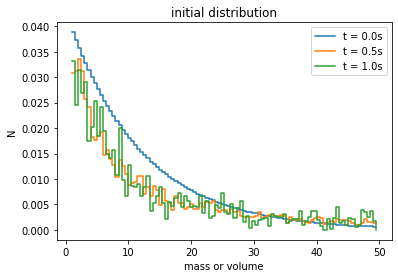

In [20]:
# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = b_golovin)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((1), (50), num=100)

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

In [22]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=1))
    builder.add_dynamic(Coalescence(kernel=Golovin(b=b_golovin)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)

# save the data
np.savetxt('blind_test_3.out', moments, header="M0(0), M1(0), M2(0), M0(1), M1(1), M2(1)")

# 4. Gamma distribution: match perfect model example

### Perfect model setup:
Gamma distribution with theta=1.5597, k=0.0817, N=300

M1(0) = N k theta = 38.23

Golovin kernel = 7.962e-4;

bM1(0) (dynamical similarity) =  .03044

### PySDM setup:
Gamma distribution with theta=1.5597, k=0.0817, N=1e7

M1(0) = 1.23e6; bM1(0) = .03044

Golovin kernel = 0.000000023886 = 2.3886e-8

Simulation time = 1 (1000 time steps)

In [39]:
# Set desired constants
b_golovin = 2.3886e-8  # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e7           # total number of droplets
end_step = int(T_sim / dt_sim)
k_shape = 0.0817
theta_scale = 1.5597

from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

9797632.0
9698962.0
9597601.0


Text(0.5, 1.0, 'initial distribution')

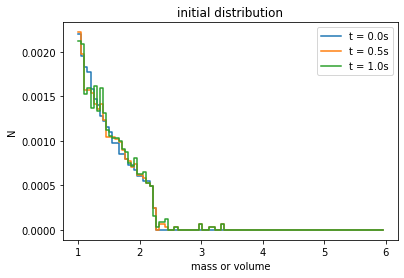

In [40]:
# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = b_golovin)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((1), (6), num=100)

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    print(particles.products['Mk'].get(0))
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

In [41]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=1))
    builder.add_dynamic(Coalescence(kernel=Golovin(b=b_golovin)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)

# save the data
np.savetxt('test4_perfectexp.out', moments, header="M0(0), M1(0), M2(0), M0(1), M1(1), M2(1)")

# 4.2 Gamma distribution: match perfect model example

### Perfect model setup:
Gamma distribution with theta=1.5597, k=0.0817, N=300

M1(0) = N k theta = 38.23

Golovin kernel = 7.962e-4;

bM1(0) (dynamical similarity) =  .03044

### PySDM setup:
Gamma distribution with theta=1.5597, k=0.0817, N=1e7

Golovin kernel = 7.962e-4

Simulation time = 1 (1000 time steps)

In [3]:
# Set desired constants
b_golovin = 7.962e-4   # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e7           # total number of droplets
end_step = int(T_sim / dt_sim)
k_shape = 0.0817
theta_scale = 1.5597

from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

9797632.0
1.0
1.0


Text(0.5, 1.0, 'initial distribution')

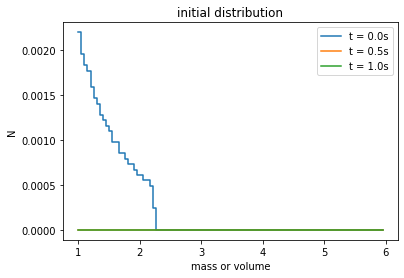

In [4]:
# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = b_golovin)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((1), (6), num=100)

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    print(particles.products['Mk'].get(0))
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")